In [1]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns

import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#datasets upload

df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

In [3]:
df_treino.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df_teste.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


# tratando os dados


#Como a empresa quer fazer a venda casada de produtos, \
#vamos trabalhar apenas com as variáveis numéricas,\
#para que o departamento responsável possa tomar\
#as devidas ações

## de treino

In [7]:
#dropando as colunas que não vamos utilizar
df_treino = df_treino.drop(['id', 'Gender','Driving_License','Region_Code','Vehicle_Age','Policy_Sales_Channel'], axis=1)
df_treino

,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response
0,44,0,Yes,40454.0,217,1
1,76,0,No,33536.0,183,0
2,47,0,Yes,38294.0,27,1
3,21,1,No,28619.0,203,0
4,29,1,No,27496.0,39,0
...,...,...,...,...,...,...
381104,74,1,No,30170.0,88,0
381105,30,1,No,40016.0,131,0
381106,21,1,No,35118.0,161,0
381107,68,0,Yes,44617.0,74,0


In [8]:
#Cuidando da coluna Vehicle_Damage
df_treino['Vehicle_Damage'] = df_treino['Vehicle_Damage'].replace({'Yes': 1, 'No': 0})

#checando a saida
df_treino.sample(2)

,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response
50853,49,1,0,2630.0,86,0
325507,25,1,0,2630.0,74,0


In [15]:
df_treino.isnull().sum()

Age                   0
Previously_Insured    0
Vehicle_Damage        0
Annual_Premium        0
Vintage               0
Response              0
dtype: int64

##  de teste

In [9]:
#dropando as colunas que não vamos utilizar
df_teste = df_teste.drop(['id', 'Gender','Driving_License','Region_Code','Vehicle_Age','Policy_Sales_Channel'], axis=1)

#Cuidando da coluna Vehicle_Damage
df_teste['Vehicle_Damage'] = df_teste['Vehicle_Damage'].replace({'Yes': 1, 'No': 0})

#checando a saida
df_teste.sample(2)

,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage
37911,22,1,0,33798.0,48
119709,28,1,0,30170.0,148


In [16]:
df_teste.isnull().sum()

Age                   0
Previously_Insured    0
Vehicle_Damage        0
Annual_Premium        0
Vintage               0
dtype: int64

In [41]:
#salvando para usar no input do streamlit
df_teste.to_csv('streamlit.csv', index= False)

# Construindo o modelo preditivo

In [24]:
#Checando o balanceamento das classes.
df_treino['Response'].value_counts()

#Como há diferença significativa dos valores da classe,\
#vamos fazer o balanceamento das classes fazendo o undersampling

0    334399
1     46710
Name: Response, dtype: int64

In [14]:
#importando a biblioteca necessária
from imblearn.under_sampling import NearMiss

<AxesSubplot:xlabel='Response', ylabel='count'>

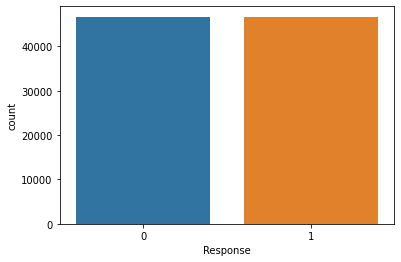

In [25]:
#Separando o X e o y

X = df_treino.drop('Response', axis = 1)
y = df_treino['Response']

#Instanciando o NearMiss
nr = NearMiss()

#Aplicando
X,y= nr.fit_resample(X,y)

#checando a amostra
sns.countplot(x=y)

Separando os dados em X_treino, y_treino

In [26]:
#Separando os dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y)

X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((70065, 5), (23355, 5), (70065,), (23355,))

Analisando a importância de cada feature

In [27]:
# Analisando a importância de cada feature
#instanciando
RF_Class = RandomForestClassifier(random_state=123)
RF_Class.fit(X,y)


#buscando as melhores features
feature_imp = pd.Series(RF_Class.feature_importances_,index=Xu.columns).sort_values(ascending=False)

# Selecionando as features de maior importância.
features_selected = []
for feature,importance in feature_imp.iteritems():
    if importance > 0.03:
        print(f'{feature}: {round(importance * 100)}%')
        features_selected.append(feature)

Annual_Premium: 64%
Vintage: 13%
Vehicle_Damage: 12%
Previously_Insured: 6%
Age: 5%


Treinando os modelos utilizando apenas as features selecionadas.

In [28]:
#Separando os dados
X_treino_u, X_teste_u, y_treino_u, y_teste_u = train_test_split(X, y)

X_treino_u.shape, X_teste_u.shape, y_treino_u.shape, y_teste_u.shape

((70065, 5), (23355, 5), (70065,), (23355,))

Regressão Logística

In [29]:
#Instanciando o modelo
lr = LogisticRegression(random_state=123)

#treinando o modelo 
lr.fit(X_treino_u, y_treino_u)

#predizendo os valores
y_pred_lr_u = lr.predict(X_teste_u)

#imprindo Relatorio de classificação
print(classification_report(y_teste_u, y_pred_lr_u))

#Matriz de confusão
print(pd.crosstab(y_teste_u, y_pred_lr_u, rownames=['Real'], colnames=['Predito'], margins=True))

#colinha
#lr_model = LogisticRegression()
#lr_model.fit(X_train, y_train)
#test_pred = lr_model.predict(X_test)


              precision    recall  f1-score   support

           0       0.85      1.00      0.92     11750
           1       1.00      0.82      0.90     11605

    accuracy                           0.91     23355
   macro avg       0.92      0.91      0.91     23355
weighted avg       0.92      0.91      0.91     23355

Predito      0     1    All
Real                       
0        11750     0  11750
1         2117  9488  11605
All      13867  9488  23355


In [37]:
#salvando o modelo
pickle.dump(lr,open('model_lr04.04.pkl','wb'))

In [38]:
#validando o modelo com df_teste

#chamando o modelo
modelo= pickle.load(open('model_lr04.04.pkl', 'rb'))

#fazendo o predict

y_pred_lr = modelo.predict(df_teste)
y_pred_lr

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [39]:
len(y_pred_lr)

127037

In [40]:
import collections


#verificando a saída do modelo
print(collections.Counter(y_pred_lr))

Counter({1: 104719, 0: 22318})


In [43]:
loaded_model = pickle.load(open('model_lr04.04.pkl', 'rb'))

In [46]:
input_data = (50,1,1,250000.0,125)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('Cliente não está interessado')
else:
  print('Cliente interessado!')

[1]
Cliente interessado!


In [2]:
#testando o arquivo 

In [3]:
df= pd.read_csv('streamlit.csv')
df

,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage
0,25,1,0,35786.0,53
1,40,0,1,33762.0,111
2,47,0,1,40050.0,199
3,24,1,1,37356.0,187
4,27,1,0,59097.0,297
...,...,...,...,...,...
127032,26,1,0,30867.0,56
127033,38,0,1,28700.0,165
127034,21,1,0,29802.0,74
127035,71,1,0,62875.0,265
